### import os
import random
import string
from collections import Counter, defaultdict
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

In [2]:
# Define paths
images_path = '/kaggle/input/flickr30k/flickr30k_images'
captions_file = '/kaggle/input/flickr30k/captions.txt'

In [3]:
# Creates a dictionary, with the image name as the key, and the caption as the value
captions = defaultdict(list)
with open(captions_file, 'r') as f:
    next(f)  # Skip the header
    for line in f:
        image, caption = line.strip().split(',', 1)
        captions[image].append(caption)

In [4]:
# Example caption
captions['1000092795.jpg']

['0,Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 '1,Two young  White males are outside near many bushes .',
 '2,Two men in green shirts are standing in a yard .',
 '3,A man in a blue shirt standing in a garden .',
 '4,Two friends enjoy time spent together .']

In [5]:
# Preprocess captions and clean the text up
def clean_caption(caption):
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove words with numbers and words of length 1
    # If the word is of length 1, or the word contains a digit, remove it from the cpation
    caption = ' '.join([word for word in caption.split() if len(word) > 1 and not any(char.isdigit() for char in word)])
    # Convert to lowercase
    caption = caption.lower()
    return caption

# Surprisingly loops over all keys
for image in captions:
    # Loops over all strings, and cleans the captions
    captions[image] = [clean_caption(caption) for caption in captions[image]]

In [6]:
# Define image transformation
transform = transforms.Compose([
    # CHANGE image size
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # TODO: Update this part of the function
    transforms.Lambda(lambda x: x[:3, :, :]),  # Ensure the image has 3 channels
])

# Load image function helper
def load_image(image_file):
    image = Image.open(os.path.join(images_path, image_file)).convert('RGB')
    image = transform(image)
    return image

In [7]:
# Build vocabulary
word_counter = Counter()
for image, caption_list in captions.items():
    # Loops through list of strings
    for caption in caption_list:
        word_counter.update(caption.split())

In [8]:
# Create dictionaries for words
vocab_threshold = 3
vocab = [word for word, count in word_counter.items() if count > vocab_threshold]
vocab_size = len(vocab) + 4  # Including <PAD>, <START>, <END>, <UNK>

In [9]:
# Add special tokens
stoi = {word: idx + 4 for idx, word in enumerate(vocab)}
stoi['<PAD>'] = 0
stoi['<START>'] = 1
stoi['<END>'] = 2
stoi['<UNK>'] = 3
itos = {idx: word for word, idx in stoi.items()}

In [10]:
def encode_caption(caption):
    # Default entry for dictionary.get()
    encoded = [stoi['<START>']] + [stoi.get(word, stoi['<UNK>']) for word in caption.split()] + [stoi['<END>']]
    return encoded

def decode_caption(encoded_caption):
    # Default entry for dictionary.get()
    return ' '.join([itos.get(idx, '<UNK>') for idx in encoded_caption])

def pad_caption(caption, max_length):
    # This actually pads one less than the max, which is not intended. But, we will keep this anyways
    return caption + [stoi['<PAD>']] * (max_length - len(caption))

In [11]:
# Calculate the max length of the cpations
# To unpack this, we are looping over the defaultdict captions. We get the list of strings called caption_list, and loop over all lists of strings in captions, and also loop over all captions in the list
# This is a very complex string comprehension
max_length = max(len(caption.split()) for caption_list in captions.values() for caption in caption_list) + 2
max_length

74

In [12]:
# Loops over all image keys, all caption lists, all captions in caption lists, encodes them, and pads them
encoded_captions = defaultdict(list)

for image in captions:
    for caption in captions[image]:
        encoded = encode_caption(caption)
        padded = pad_caption(encoded, max_length)
        encoded_captions[image].append(padded)

In [13]:
# Function to create input and target sequences
def create_sequences(encoded_caption):
    input_sequence = encoded_caption[:-1]
    target_sequence = encoded_caption[1:]
    return input_sequence, target_sequence

In [14]:
# Create input and target sequences for all captions
input_sequences = defaultdict(list)
target_sequences = defaultdict(list)

for image, caption_list in encoded_captions.items():
    for caption in caption_list:
        # Loop through all captions in all caption_lists, and create the corresponding token lists
        input_seq, target_seq = create_sequences(caption)
        # Create another defaultdict() that allows for indexing of the processed list tokens
        input_sequences[image].append(input_seq)
        target_sequences[image].append(target_seq)

In [15]:
# Creating randomized batches
image_keys = list(captions.keys())

In [16]:
torch.manual_seed(1337)

In [17]:
# Shuffle the dataset
shuffled_indices = torch.randperm(len(image_keys)).tolist()
image_keys = [image_keys[i] for i in shuffled_indices]

In [18]:
# Split the dataset (80% training, 20% validation)
split_index = int(0.8 * len(image_keys))
train_keys = image_keys[:split_index]
val_keys = image_keys[split_index:]

In [19]:
# Train and validation sets
train_captions = {key: captions[key] for key in train_keys}
val_captions = {key: captions[key] for key in val_keys}
train_input_sequences = {key: input_sequences[key] for key in train_keys}
val_input_sequences = {key: input_sequences[key] for key in val_keys}
train_target_sequences = {key: target_sequences[key] for key in train_keys}
val_target_sequences = {key: target_sequences[key] for key in val_keys}

In [20]:
def create_batch(caption_dict, input_seq_dict, target_seq_dict, batch_size):
    images_batch = []
    input_captions_batch = []
    target_captions_batch = []
    
    selected_images = random.sample(list(caption_dict.keys()), batch_size)
    for image in selected_images:
        # Pick a random index from one of the caption lists
        selected_caption_idx = random.randint(0, len(caption_dict[image]) - 1)
        # Add the corresponding image caption
        input_captions_batch.append(input_seq_dict[image][selected_caption_idx])
        # Get the corresponding target_caption
        target_captions_batch.append(target_seq_dict[image][selected_caption_idx])
        # Add the image to the corresponding image to the image set
        images_batch.append(load_image(image))
    
    images_batch = torch.stack(images_batch)
    input_captions_batch = torch.tensor(input_captions_batch)
    target_captions_batch = torch.tensor(target_captions_batch)
    
    return images_batch, input_captions_batch, target_captions_batch


In [21]:
# Example usage:
batch_size = 4
images_batch, input_captions_batch, target_captions_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, batch_size)


In [22]:
images_batch.shape

torch.Size([4, 3, 224, 224])

In [23]:
input_captions_batch.shape

torch.Size([4, 73])

In [24]:
target_captions_batch.shape

torch.Size([4, 73])

Training example:


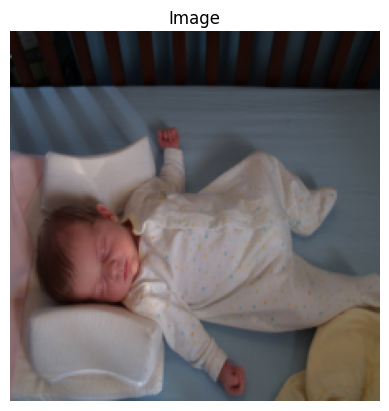

Input Caption: <START> baby wearing white <UNK> is sleeping in crib <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: baby wearing white <UNK> is sleeping in crib <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Validation example:


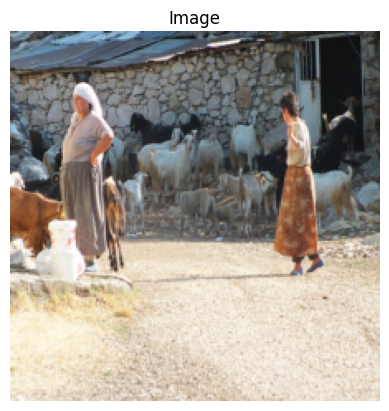

Input Caption: <START> women stand in front of herd of goats <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: women stand in front of herd of goats <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [25]:
def visualize_example(caption_dict, input_seq_dict, target_seq_dict):
    
    # Select a random image
    random_image = random.choice(list(caption_dict.keys()))
    
    # Select a random caption index for the chosen image
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    # Load the image
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    # Get the corresponding caption inputs and targets
    input_caption_encoded = input_seq_dict[random_image][caption_idx]
    target_caption_encoded = target_seq_dict[random_image][caption_idx]
    input_caption = decode_caption(input_caption_encoded)
    target_caption = decode_caption(target_caption_encoded)
    
    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    # Print the input and target captions
    print(f"Input Caption: {input_caption}")
    print(f"Target Caption: {target_caption}")

# Example usage:
print("Training example:")
visualize_example(train_captions, train_input_sequences, train_target_sequences)

print("Validation example:")
visualize_example(val_captions, val_input_sequences, val_target_sequences)


In [26]:
class ConvNet(nn.Module):
    def __init__(self, dropout):
        super(ConvNet, self).__init__()
        
        # Load the pretrained ResNet50 model
        self.resnet50 = models.resnet50(pretrained=True)
        
        # Freeze all the ResNet50 layers except the last fully connected layer
        for param in self.resnet50.parameters():
            param.requires_grad = False
        for param in self.resnet50.fc.parameters():
            param.requires_grad = True
        
        # Add dropout before the final fully connected layer
        self.resnet50.fc = nn.Sequential(
            nn.Dropout(dropout),
            self.resnet50.fc
        )
    
    def forward(self, inputs):  # (224, 224, 3)
        out = self.resnet50(inputs)
        return out  # (B, 1000)

In [27]:
class Decoder(nn.Module):
    def __init__(self, channels_in, dropout, vocab_size, hidden_size, n_embd, n_head, n_layer, block_size):
        super(Decoder, self).__init__()
        
        self.convnet = ConvNet(dropout=dropout)
        
        self.linear_proj = nn.Linear(1000, n_embd)  # Adjust input size based on CNN output (B, n_embd)
        
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        
        # We don't need to increment block_size by 1 yet, we only need to increment it when we pass it into the Transformer blocks
        self.positional_embedding = nn.Embedding(block_size, n_embd)
        
        self.transformer_blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)]) # Block(n_embd, n_head)
        self.ln_f = nn.LayerNorm(n_embd)
        self.fc_out = nn.Linear(n_embd, vocab_size)
        
    def forward(self, images, captions):
        # Process images through CNN
        cnn_features = self.convnet(images)  # (B, 4096)
        
        cnn_features = self.linear_proj(cnn_features)  # (B, n_embd) output
        
        # Expand dimensions to (B, 1, n_embd) to represent single token embedding
        cnn_features = cnn_features.unsqueeze(1) # (B, 1, n_embd)
        
        # Process captions
        captions = self.token_embedding(captions)  # (B, T, n_embd)
        
        # Add positional encodings
        batch_size, seq_length = captions.shape[:2] # (B, T)
        
        pos_encoding = self.positional_embedding(torch.arange(seq_length, device=images.device)).unsqueeze(0).expand(batch_size, -1, -1)
        
        # Combine CNN features with caption embeddings
        inputs = torch.cat((cnn_features, captions + pos_encoding), dim=1)  # (B, T+1, n_embd) --- Concatenated along the T dimension
        
        # Pass through Transformer blocks
        
        x = self.transformer_blocks(inputs)
        
        x = self.ln_f(x)
        
        # Apply final linear layer
        logits = self.fc_out(x)  # (B, 1+T, vocab_size)
        
        # Remove the logits corresponding to the initial CNN feature
        logits = logits[:, 1:, :]  # (B, T, vocab_size)
        
        return logits


In [28]:
# class Transformer(nn.Module):
#     def __init__(self, n_embd, n_head, n_layer, block_size, vocab_size, dropout):
#         super().__init__()

#         self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
#         self.position_embedding_table = nn.Embedding(block_size + 1, n_embd)

#         self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
#         self.ln_f = nn.LayerNorm(n_embd)
#         self.lm_head = nn.Linear(n_embd, vocab_size)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, idx):
#         B, T = idx.shape
#         tok_emb = self.token_embedding_table(idx)  # (B, T, C)
#         pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T, C)
#         x = tok_emb + pos_emb  # (B, T, C)
#         x = self.blocks(x)
#         x = self.ln_f(x)
#         logits = self.lm_head(x)  # (B, T, vocab_size)

#         return logits

In [29]:
class Block(nn.Module):
    # (B, T+1, n_embd)
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head # 512 / 8 = 64
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))  # Residual connection
        x = x + self.ffwd(self.ln2(x))
        return x

In [30]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [31]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size): # (8, 64)
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, num_heads * head_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [32]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size + 1, block_size + 1)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

In [45]:
# UPDATE the model parameters here

device = torch.device(0 if torch.cuda.is_available() else 'cpu')

num_iterations = 2000

nepochs = 2000

learning_rate = 1e-4

channels_in = 3

dropout = 0.4

vocab_size = len(stoi)

hidden_size = 1024

batch_size = 64

max_length = max_length

### Contributes to most of the total parameters?

# n_embd % n_head == 0

n_embd = 1024  # Quadrupled from 512

n_head = 16  # Quadrupled from 8

n_layer = 16  # Doubled from 8 to reach quadrupled parameters

# Here, we are actually 
block_size = max_length - 1  # Sequence length (maximum length of input sequence)

In [46]:
# Initialize the model
model = Decoder(
    channels_in=channels_in, 
    dropout=dropout, 
    vocab_size=vocab_size, 
    hidden_size=hidden_size, 
    n_embd=n_embd, 
    n_head=n_head, 
    n_layer=n_layer, 
    block_size=block_size
).to(device)

# Optimizer and learning rate scheduler

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs, eta_min=0)

# Loss function
loss_fn = nn.CrossEntropyLoss()

training_loss = []

val_loss = []

In [47]:
# Let's see how many Parameters our model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("This model Has %d Parameters, %d Million" % (num_model_params, num_model_params//1e6 ) )

This model Has 245559641 Parameters, 245 Million


In [48]:
def calculate_average_val_loss(model, val_captions, val_input_sequences, val_target_sequences, batch_size, loss_fn, num_examples=100):
    model.eval()
    total_loss = 0
    num_batches = 0
    examples_processed = 0
    
    with torch.no_grad():
        while examples_processed < num_examples:
            image_batch, caption_batch, label_batch = create_batch(val_captions, val_input_sequences, val_target_sequences, batch_size)
            current_batch_size = image_batch.size(0)
            image_batch = image_batch.to(device)
            caption_batch = caption_batch.to(device)
            label_batch = label_batch.to(device)
            
            outputs = model(image_batch, caption_batch)
            outputs = outputs.reshape(current_batch_size * block_size, -1)
            label_batch = label_batch.reshape(current_batch_size * block_size)
            
            loss = loss_fn(outputs, label_batch)
            total_loss += loss.item() * current_batch_size
            examples_processed += current_batch_size
            num_batches += 1
    
    average_loss = total_loss / examples_processed
    return average_loss

# # Example usage within the training loop
# average_val_loss = calculate_average_val_loss(model, val_captions, val_input_sequences, val_target_sequences, batch_size, loss_fn)
# print("iteration", iteration, "average val loss:", average_val_loss)


In [49]:
# Training loop
for iteration in range(num_iterations):
    # Training
    model.train()

    image_batch, caption_batch, label_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, batch_size)

    image_batch = image_batch.to(device)
    caption_batch = caption_batch.to(device)
    label_batch = label_batch.to(device)
    
    outputs = model(image_batch, caption_batch)

    outputs = outputs.reshape(batch_size * block_size, -1)
    label_batch = label_batch.reshape(batch_size * block_size)

    loss = loss_fn(outputs, label_batch)
    training_loss.append(loss.item())

    if iteration % 10 == 0: 
        print("iteration", iteration, "training loss:", loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate every so often
    if iteration % 10 == 0:
        model.eval()
        image_batch, caption_batch, label_batch = create_batch(val_captions, val_input_sequences, val_target_sequences, batch_size)
    
        image_batch = image_batch.to(device)
        caption_batch = caption_batch.to(device)
        label_batch = label_batch.to(device)
        
        outputs = model(image_batch, caption_batch)
        outputs = outputs.reshape(batch_size * block_size, -1)
        label_batch = label_batch.reshape(batch_size * block_size)
    
        loss = loss_fn(outputs, label_batch)
        val_loss.append(loss.item())
        
        print("iteration", iteration, "val loss:", loss.item())
        
    if iteration % 100 == 0:
        avg_val_loss = calculate_average_val_loss(model, val_captions, val_input_sequences, val_target_sequences, batch_size, loss_fn)
        print("------")
        print("iteration", iteration, "avg val loss:", avg_val_loss)
        print("------")

    lr_scheduler.step()

iteration 0 training loss: 8.547452926635742
iteration 0 val loss: 1.7284709215164185
------
iteration 0 avg val loss: 1.71164470911026
------
iteration 10 training loss: 1.144950032234192
iteration 10 val loss: 1.2629708051681519
iteration 20 training loss: 0.9840863347053528
iteration 20 val loss: 1.1284058094024658
iteration 30 training loss: 1.0418660640716553
iteration 30 val loss: 0.9122557044029236
iteration 40 training loss: 0.9306154847145081
iteration 40 val loss: 0.9394335746765137
iteration 50 training loss: 0.8708269596099854
iteration 50 val loss: 0.8761087656021118
iteration 60 training loss: 0.9313070178031921
iteration 60 val loss: 0.9208622574806213
iteration 70 training loss: 0.8410981893539429
iteration 70 val loss: 0.9268174767494202
iteration 80 training loss: 0.8297187089920044
iteration 80 val loss: 0.8524450063705444
iteration 90 training loss: 0.8245168328285217
iteration 90 val loss: 0.9611103534698486
iteration 100 training loss: 0.9335762858390808
iteration

In [52]:
torch.save(model, 'image-captioning.pth')

In [ ]:
# Specify the path to the saved model file
model_path = 'models/image-captioning.pth'

# Load the entire model (architecture + trained parameters)
model = torch.load(model_path)

Text(0.5, 1.0, 'Training loss')

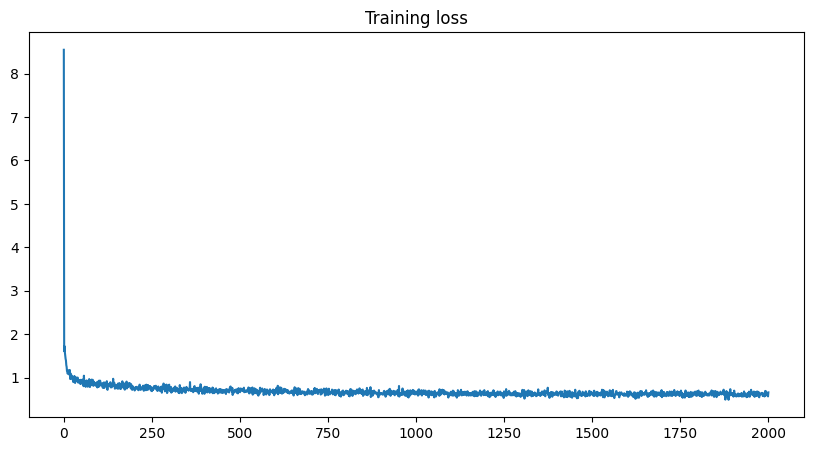

In [53]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_iterations, len(training_loss))
plt.plot(train_x, training_loss)
plt.title("Training loss")

Text(0.5, 1.0, 'Val loss')

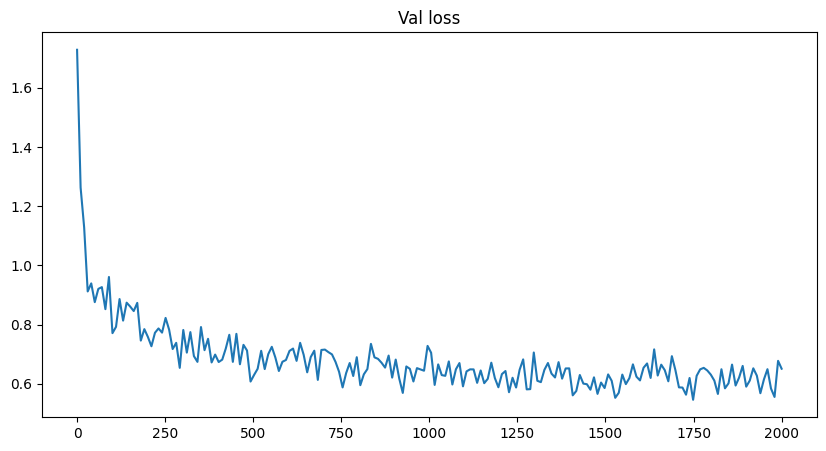

In [54]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_iterations, len(val_loss))
plt.plot(train_x, val_loss)
plt.title("Val loss")

In [ ]:
max_length = 30

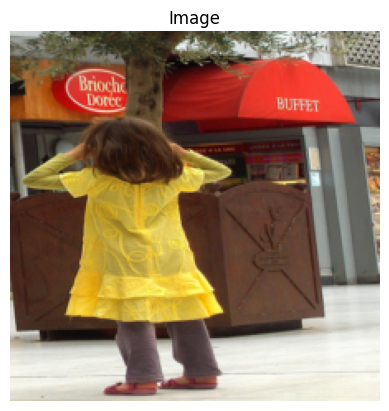

Original Caption: <START> girl in yellow dress looks at restaurant building <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: woman in red shirt and black pants is walking down the street <END>
Generated Caption: woman in red shirt and black pants is walking down the street <END>
Generated Caption: woman in red shirt and black pants is walking down the street <END>
Generated Caption: woman in red shirt and black pants is walking down the street <END>
Generated Caption: woman in red shirt and black pants is walking down the street <END>


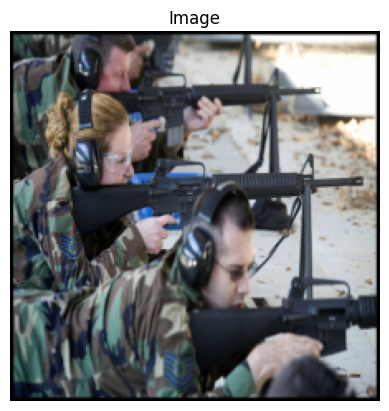

Original Caption: <START> personnel shoot rifles <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: man in black shirt is sitting on the sidewalk <END>
Generated Caption: man in black shirt is sitting on the sidewalk <END>
Generated Caption: man in black shirt is sitting on the sidewalk <END>


In [ ]:
def sample_caption(model, image, max_length=30):
    model.eval()
    
    sos_token = torch.tensor([[stoi['<START>']]], device=device)
    
    with torch.no_grad():
        # Process the image through the CNN part of the model
        image = image.to(device)
        cnn_features = model.convnet(image.unsqueeze(0))
        cnn_features = model.linear_proj(cnn_features.view(cnn_features.size(0), -1))
        cnn_features = cnn_features.unsqueeze(1)  # (B, 1, n_embd)
        
        # Initialize input tokens with the <sos> token
        input_tokens = sos_token
        
        generated_caption = []
        
        for _ in range(max_length):
            # Embed the input tokens
            input_embedded = model.token_embedding(input_tokens)
            
            # Add positional encoding for the current input tokens
            seq_length = input_tokens.size(1)
            pos_encoding = model.positional_embedding(torch.arange(seq_length, device=device)).unsqueeze(0)
            
            # Combine CNN features with input embeddings and positional encodings
            inputs = torch.cat((cnn_features, input_embedded + pos_encoding), dim=1)
            
            # Pass through the transformer blocks
            output = model.transformer_blocks(inputs)
            output = model.ln_f(output)
            
            # Apply final linear layer
            logits = model.fc_out(output)  # (B, T+1, vocab_size)
            
            # Get the logits for the next token
            logits = logits[:, -1, :]  # (B, vocab_size)
            
            # Softmax to get probabilities
            probabilities = F.softmax(logits, dim=-1)
            
            # Sample from the probability distribution
#             next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = torch.argmax(probabilities, dim=-1).unsqueeze(0)
            
            # Append the generated token to the caption
            generated_token = itos[next_token.item()]
            generated_caption.append(generated_token)
            
            # Concatenate the current input token with previously generated tokens
            input_tokens = torch.cat([input_tokens, next_token], dim=1)
            
            # If <END> token is generated or <PAD> token (assuming stoi['<PAD>'] == 0), stop
            if next_token.item() == stoi['<END>'] or next_token.item() == stoi['<PAD>']:
                break
    
    return generated_caption


def visualize_example(model, caption_dict, input_seq_dict, target_seq_dict, max_length=30):
    random_image = random.choice(list(caption_dict.keys()))
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    image_tensor = load_image(random_image)  # Assuming load_image function loads and preprocesses the image
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    original_caption_encoded = input_seq_dict[random_image][caption_idx]
    original_caption = decode_caption(original_caption_encoded)  # Function to decode integer-encoded caption
    print(f"Original Caption: {original_caption}")
    
    # Generate a caption using the model
    for _ in range(5):
        generated_caption = sample_caption(model, image_tensor, max_length)
        generated_caption_str = ' '.join(generated_caption)
        print(f"Generated Caption: {generated_caption_str}")

# Example usage:
num_samples = 5

for _ in range(num_samples):
    visualize_example(model, val_captions, val_input_sequences, val_target_sequences, max_length=max_length)

# print("----")

# for _ in range(num_samples):
#     visualize_example(model, train_captions, train_input_sequences, train_target_sequences, max_length=max_length)